## Persian Affiliations

annotations dir: محل ذخیره ی فایل های نشانه گذاری شده

json name format: نحوه ی نام گذاری فایل های جیسون

papers text dir: محل ذخیره ی فایل های متنی صفحه ی اول مقالات

text name format: نحوه ی نام گذاری فایل های متنی

In [1]:
ANNOTATIONS_DIR = 'annotations/'
JSON_NAME_FORMAT = 'metadata_ paper{number}.json'

PAPERS_TEXT_DIR = 'train/'
TXT_NAME_FORMAT = '{number}.txt'

In [2]:
import os

یافتن اندیس کلمه در جمله

In [3]:
def find_abstract_index(sentence, word):
    try:
        return sentence.index(word)
    except ValueError:
        return None

تابع محاسبه ی شباهت دو رشته بر اساس شاخص کسینوسی

In [4]:
def cosine_sim(first, second):
    X = {word for word in first.split()}
    Y = {word for word in second.split()}

    l1 = []
    l2 = []

    rvector = X.union(Y)  
    for w in rvector:
        if w in X:
            l1.append(1)
        else:
            l1.append(0) 
        if w in Y:
            l2.append(1) 
        else:
            l2.append(0)
    c = 0

    for i in range(len(rvector)): 
            c += l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    
    return cosine

شمارش تعداد کلمات مرتبط در یک خط

In [5]:
def count_affiliation_related_words(line):
    affiliation_related_words = ['دانشگاه', 'استاد', 'کارشناسی', 'ارشد', 'دکتری',\
                                 'دانشکده', 'هیئت علمی', 'هیأت علمی', 'گروه', 'نویسنده'\
                                 'رشته', 'مربی', 'استادیار', 'دانشیار', 'استاد تمام',\
                                 'مدرس', 'دبیر', 'مکاتبات', 'پژوهشگاه', 'پژوهشگر']
    cnt = 0
    for arw in affiliation_related_words:
        if arw in line:
            cnt += 1
    return cnt+1 if 'استان' in line or 'شهرستان' in line or 'علمی' in line else cnt

پیمایش روی فایل های آموزش

In [6]:
import re

In [7]:
paper_numbers = [re.search(r'\b\d+\b', s).group() for s in \
                 [file_name for file_name in sorted(os.listdir(PAPERS_TEXT_DIR))]]
paper_numbers

['1',
 '14',
 '167',
 '171',
 '172',
 '20',
 '201',
 '24',
 '25',
 '26',
 '28',
 '3',
 '42',
 '43',
 '465',
 '468',
 '469',
 '472',
 '473',
 '474',
 '478',
 '479',
 '480',
 '481',
 '6',
 '601',
 '62',
 '66',
 '69',
 '7',
 '70',
 '71',
 '8',
 '9',
 '98']

In [8]:
import json

In [9]:
searched_affiliations = {}
measures = {'FP':0, 'FN':0, 'CR':0}

avg_sim, cnt = 0, 0
for paper_number in paper_numbers:
    searched_affiliations[paper_number] = []
    found_set = set()
    
    annotated_aff = "-"
    searched_aff = "-"

    json_name = JSON_NAME_FORMAT.format(number=paper_number)
    txt_name = TXT_NAME_FORMAT.format(number=paper_number)
    print("\n", '~'*20, txt_name, ' VS ', json_name, '~'*20)

    with open(PAPERS_TEXT_DIR+txt_name, 'r') as txt_file:

        print('\nannotated:\n')
        with open(ANNOTATIONS_DIR+json_name) as json_file:
            affs_dict = json.load(json_file)
            if 'affiliations' in affs_dict:
                for aff in affs_dict['affiliations']:
                    annotated_aff += aff
                    print(aff+'\n')
        
        regular_order = txt_file.read().split('\n')
        print('\nsearched:\n')
        for i, line in enumerate(regular_order):
#             print("iterate *****************", line)
            if find_abstract_index(line, 'چکیده') != None \
            or find_abstract_index(line, 'پیشگفتار') != None \
            or find_abstract_index(line, 'کلید') != None:
#                 chekide = not chekide
                break
            if count_affiliation_related_words(line) >= 2:
                found_set.add(i)
                searched_aff += line
                print(line+'\n')
                searched_affiliations[paper_number].append(line)
        
        reversed_order = reversed(regular_order)
        reversed_results = []
        for i, line in enumerate(reversed_order):
#             print("reversed ~~~~~~~~~~~~~~~~", line)
            if find_abstract_index(line, 'چکیده') != None \
            or find_abstract_index(line, 'پیشگفتار') != None \
            or find_abstract_index(line, 'کلید') != None:
                break
            if count_affiliation_related_words(line) >= 2:
                idx = len(regular_order)-i-1
                if idx in found_set:
                    continue
                else:
                    found_set.add(idx)
                    searched_aff = line + searched_aff
                    print(line+'\n')
                    reversed_results.append(line)
        searched_affiliations[paper_number] += reversed_results[::-1]
        
    cnt += 1
    cs = cosine_sim(annotated_aff, searched_aff)
    measures['CR'] += cs
    if cs == 1:
        print("CORRECT")
    elif len(annotated_aff) > len(searched_aff):
        measures['FN'] += 1 #-cs
        print("FALSE NEGATIVE")
    else:
        measures['FP'] += 1 #-cs
        print("FALSE POSITIVE")
    print("{:.2f}".format(cs))
    avg_sim += cs

avg_sim /= cnt


 ~~~~~~~~~~~~~~~~~~~~ 1.txt  VS  metadata_ paper1.json ~~~~~~~~~~~~~~~~~~~~

annotated:

استاد سازه، دانشگاه صنعتی شریف

دانشجوی دکتری، دانشگاه صنعتی شریف


searched:

" دانشجوی دکتری، دانشگاه صنعتی شریف: تلفن: ۱۹۱۹۶۲۷۶-۰۲۱ : پست الکترونیکی:

استاد سازه، دانشگاه صنعتی شریف; تلفن: ۱۹۱۹۶۲۱۱-۰۲۱ : پست الكترونیكی:

FALSE POSITIVE
0.39

 ~~~~~~~~~~~~~~~~~~~~ 14.txt  VS  metadata_ paper14.json ~~~~~~~~~~~~~~~~~~~~

annotated:

استادیار دانشگاه آزاد اسلامی، واحد اسلامشهر


searched:

استادیار دانشگاه آزاد اسلامی، واحد اسلامشهر

CORRECT
1.00

 ~~~~~~~~~~~~~~~~~~~~ 167.txt  VS  metadata_ paper167.json ~~~~~~~~~~~~~~~~~~~~

annotated:

پژوهشگاه علوم انسانی و مطالعات اجتماعی جهاد دانشگاهی

دانشکده روانشناسی و علوم تربیتی دانشگاه تهران

هیات علمی دانشیار پژوهشکده تحقیقات راهبردی مجمع تشخیص مصلحت نظام


searched:

فراگیر دکتری آینده پژوهی، پژوهشگاه علوم انسانی و مطالعات اجتماعی جهاد دانشگاهی، هیات علمی(مربی) دانشگاه علوم پزشکی تهران

هیات علمی(استادیار دانشکده روانشناسی و علوم تربیتی دانشگاه تهران

In [10]:
avg_sim

0.8437931943798187

مقایسه ی نسبی درصد جستجوهای صحیح و غلط

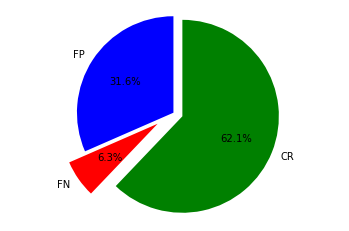

In [11]:
import matplotlib.pyplot as plt

labels = 'FP', 'FN', 'CR'
colors = 'blue', 'red', 'green'
explode = (0, 0.2, 0.1) 
sizes = [x for x in measures.values()]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')

plt.show()

استخراج ایمیل های موجود در صفحه ی اول مقالات

In [12]:
searched_emails = {}

for paper_number in paper_numbers:
    searched_emails[paper_number] = []

    txt_name = TXT_NAME_FORMAT.format(number=paper_number)
    with open(PAPERS_TEXT_DIR+txt_name, 'r') as txt_file:
        contents = ''.join([line.strip() for line in txt_file.readlines()])
        searched_emails[paper_number] = re.findall('[a-z][a-z0-9._-]*@[a-zA-Z]+\.[A-Za-z]{1,3}'\
                                            , contents.replace(' ', ''))

In [13]:
searched_emails

{'1': ['khaloo@sharif.edu', 'dehestani@civil.sha'],
 '14': ['shamsmohammadjavad@yahoo.com'],
 '167': ['hemmati@tums.ac', 'mgodarzi@ut.ac', 'ebhajiani@gmail.com'],
 '171': ['ommani75451@yahoo.com'],
 '172': ['makkipour@gmail.com'],
 '20': ['ramezani_masoud@yahoo.com'],
 '201': [],
 '24': ['j_firoozi@yahoo.com', 'tz.378945@gmail.com'],
 '25': [],
 '26': ['lale_20062006@yahoo.com'],
 '28': ['nakhaei.nas@gmail.Com'],
 '3': ['sahar.dehyouri@gmail.com'],
 '42': ['zhalezarei@yahoo.com', 'komijani@ut.ac'],
 '43': [],
 '465': ['younes.goli67@gmail.com', 'derakhshan.haidary@yahoo.com'],
 '468': [],
 '469': [],
 '472': ['dr.haddadian@gmail.com'],
 '473': ['hamidieh@ut.ac'],
 '474': ['lhoosh@alzahra.ac'],
 '478': ['shirazi_b@yahoo.com'],
 '479': ['agherzadeh_eco58@yahoo.com', 'omijani@ut.ac'],
 '480': ['nonahal@gmail.com'],
 '481': [],
 '6': ['allahyari@iaurasht.ac'],
 '601': ['drsalehi@iausari.ac', 'm.t_motamed@yahoo.com'],
 '62': ['drsalimpour@gmail.com'],
 '66': ['m.sheikhi@yahoo.com'],
 '69': 

In [14]:
searched_affiliations

{'1': ['استاد سازه، دانشگاه صنعتی شریف; تلفن: ۱۹۱۹۶۲۱۱-۰۲۱ : پست الكترونیكی:',
  '" دانشجوی دکتری، دانشگاه صنعتی شریف: تلفن: ۱۹۱۹۶۲۷۶-۰۲۱ : پست الکترونیکی:'],
 '14': ['استادیار دانشگاه آزاد اسلامی، واحد اسلامشهر'],
 '167': ['فراگیر دکتری آینده پژوهی، پژوهشگاه علوم انسانی و مطالعات اجتماعی جهاد دانشگاهی، هیات علمی(مربی) دانشگاه علوم پزشکی تهران',
  'هیات علمی(استادیار دانشکده روانشناسی و علوم تربیتی دانشگاه تهران',
  'هیات علمی دانشیار پژوهشکده تحقیقات راهبردی مجمع تشخیص مصلحت نظام'],
 '171': ['استادیار دانشگاه آزاد اسلامی، واحد شوشتر، شوشتر، ایران',
  'دانش آموخته کارشناسی ارشد مدیریت کشاورزی، دانشگاه آزاد اسلامی، واحد شوشتر، شوشتر، ایران'],
 '172': ['۱- کارشناس ارشد حسابداری، دانشگاه آزاد اسلامی، واحد علوم و تحقیقات، تهران، ایران. (مسئول مکاتبات)',
  '۲- استاد تمام حسابداری و مدیریت مالی ، دانشگاه شهید چمران، اهواز ، ایران.'],
 '20': ['عضو هیأت علمی دانشگاه آزاد اسلامی واحد اصفهان (خوراسگان)، ایران',
  'دانشجوی دکتری توسعه کشاورزی، دانشگاه رازی کرمانشاه، ایران',
  'دانشیار دانشکده کشا